In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import keras
import tensorflow as tf

Using TensorFlow backend.
/Users/noe/anaconda/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


In [2]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

In [3]:
import mdtraj, nglview

In [4]:
rcParams.update({'font.size': 16})

In [5]:
# Switch AUTORELOAD ON. Disable this when in production mode!
%load_ext autoreload
%autoreload 2

In [6]:
from deep_boltzmann.networks.invertible import create_RealNVPNet, create_NICERNet, EnergyInvNet
from deep_boltzmann.sampling import GaussianPriorMCMC, MetropolisGauss
from deep_boltzmann.networks.plot import test_xz_projection, test_generate_x
from deep_boltzmann.util import count_transitions
from deep_boltzmann.sampling.analysis import free_energy_bootstrap, mean_finite, std_finite
from deep_boltzmann.sampling.metropolis import MetropolisGauss, ReplicaExchangeMetropolisGauss
from deep_boltzmann.models.MM import MM, TopPar, build_hydrocarbon
from deep_boltzmann.models.conformations import RotamerMapper
from deep_boltzmann.util import save_obj, load_obj

Generic functions
----

In [9]:
def permute_align(traj, ref):
    size = traj.xyz.shape[1]
    copies = []
    rmsds = []
    # make (size) copies and consider all ring shifts
    for i in range(size):
        xyzroll = np.roll(traj.xyz.copy(), i, axis=1)
        trajroll = mdtraj.Trajectory(xyzroll, top)
        trajroll = trajroll.superpose(ref)
        copies.append(trajroll)
        rmsds.append(mdtraj.rmsd(trajroll, ref))
    # invert and the same
    #for i in range(size):
    #    xyzroll = np.roll(traj.xyz[:, ::-1, :].copy(), i, axis=1)
    #    trajroll = mdtraj.Trajectory(xyzroll, top)
    #    trajroll = trajroll.superpose(ref)
    #    copies.append(trajroll)
    #    rmsds.append(mdtraj.rmsd(trajroll, ref))
    # select the minimum rmsd, respectively
    Iclosest = np.argmin(np.vstack(rmsds), axis=0)
    xyz_closest = np.zeros_like(traj.xyz)
    for t in range(xyz_closest.shape[0]):
        xyz_closest[t] = copies[Iclosest[t]].xyz[t]
    traj_perm_align = mdtraj.Trajectory(xyz_closest, top)
    return traj_perm_align

In [7]:
def list_rotamers(sx, Ex, selected_torsions):
    # find rotamers
    torsions = mm_cyc9.torsions(sx)[:, np.array(selected_torsions)]
    torsion_index = rotamer_mapper.torsion2index(torsions)
    rotamer_index, rotamer_key, rotamer_count = rotamer_mapper.histogram(torsion_index)
    Isort = np.argsort(rotamer_count)[::-1]
    for i in Isort:
        p_i = rotamer_count[i] / rotamer_count.sum()
        It = np.where(torsion_index == rotamer_index[i])[0]
        print(rotamer_index[i], '\t', rotamer_key[i], '\t', p_i, '\t', -np.log(p_i), '\t', Ex[It].min())
    return torsions, torsion_index, rotamer_index[Isort], [rotamer_key[i] for i in Isort], rotamer_count[Isort]

In [8]:
def resample_by_rotamer(sx, nsample, nrot, torsion_index, rotamer_index):
    nrot_selected = min(nrot, len(rotamer_index))
    nsample_per_nrot = int(nsample / nrot_selected)
    xcur = []
    for i in range(nrot_selected):
        It = np.where(torsion_index == rotamer_index[i])[0]
        It_sample = np.random.choice(It, nsample_per_nrot, replace=True)
        xcur.append(sx[It_sample])
    xcur = np.vstack(xcur)
    return xcur

Cyclononane
-----

In [7]:
Cbonds = [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 0]]
toppar_cyc9 = build_hydrocarbon(9, Cbonds)
mm_cyc9 = MM(toppar_cyc9, align=0.0)
top_cyc9 = toppar_cyc9.mdtraj_topology()

In [8]:
rotamer_mapper = RotamerMapper(9)

In [9]:
Ctor = []
for i, tor in enumerate(toppar_cyc9.torsion_indices):
    is_Ctor = True
    for j in tor:
        if not toppar_cyc9.atom_names[j].startswith('C'):
            is_Ctor = False
    if is_Ctor:
        Ctor.append(i)

In [10]:
x0_cyc9 = np.random.randn(toppar_cyc9.natoms*3)

In [11]:
temperatures = np.arange(1.0, 4.5, 0.5)
remd_cyc9 = ReplicaExchangeMetropolisGauss(mm_cyc9, x0_cyc9, temperatures, noise=0.01, burnin=10000, stride=10)

** Generate and store data (first time execution) ** 

In [18]:
remd_cyc9.run(nepochs=25000, nsteps_per_epoch=10)

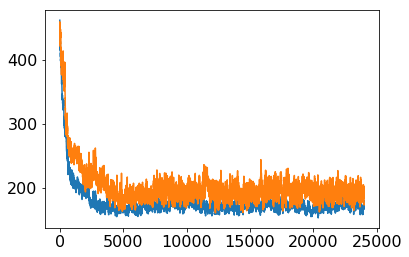

In [19]:
plt.plot(remd_cyc9.etrajs[0])
plt.plot(remd_cyc9.etrajs[1])

In [48]:
# store data
remd_dict = {}
remd_dict['temperatures'] = remd_cyc9.temperatures
remd_dict['trajs'] = remd_cyc9.trajs
save_obj(remd_dict, '../local_data/hydrocarbon_cyc9/remd_data.pkl')

** Next executions: load data and continue **

In [12]:
remd_dict = load_obj('../local_data/hydrocarbon_cyc9/remd_data.pkl')

In [16]:
traj = mdtraj.Trajectory(remd_dict['trajs'][0].reshape(remd_dict['trajs'][0].shape[0], toppar_cyc9.natoms, 3), top_cyc9)
traj = traj[10000:]
traj = traj.superpose(traj[0])

In [18]:
view = nglview.show_mdtraj(traj)
view.camera = 'orthographic'
view

NGLWidget(count=14000)

In [19]:
torsions = mm_cyc9.torsions(traj.xyz.reshape(traj.xyz.shape[0], 3*toppar_cyc9.natoms))[:, np.array(Ctor)]
tor_i_md = rotamer_mapper.torsion2index(torsions)

In [20]:
di_md, k_md, c_md = rotamer_mapper.histogram(tor_i_md)
for i in range(len(c_md)):
    p_i = c_md[i] / c_md.sum()
    print(di_md[i], '\t', k_md[i], '\t', p_i, '\t', -np.log(p_i))

1067 	 [0 0 1 1 1 0 1 1 2] 	 0.06075446724023825 	 2.800914664646295
3202 	 [0 1 1 1 0 1 1 2 1] 	 0.2794176042356056 	 1.2750478268585193
3499 	 [0 1 1 2 1 0 1 2 1] 	 0.06644606221045665 	 2.7113647550151105
10169 	 [1 1 1 2 2 1 1 2 2] 	 0.5878226340172071 	 0.5313300194147377
10826 	 [1 1 2 2 1 1 2 2 2] 	 0.0055592322964923896 	 5.1922952564234715


Boltzmann generator (example for training - see scripts for actual training)
-----

In [28]:
xtrain = traj.xyz.reshape((traj.xyz.shape[0], 3*toppar_cyc9.natoms))

In [29]:
network = create_RealNVPNet(mm_cyc9, nlayers=4, nl_activation='tanh')

In [30]:
hml = network.train_ML(xtrain, lr=0.002, epochs=500)

Epoch 1/500
14000/14000 [==============================] - 5s 368us/step - loss: 18.5915
Epoch 2/500
14000/14000 [==============================] - 1s 86us/step - loss: -72.7969
Epoch 3/500
14000/14000 [==============================] - 1s 87us/step - loss: -111.3308
Epoch 4/500
14000/14000 [==============================] - 1s 84us/step - loss: -130.5192
Epoch 5/500
14000/14000 [==============================] - 1s 92us/step - loss: -124.9577
Epoch 6/500
14000/14000 [==============================] - 1s 90us/step - loss: -143.7016
Epoch 7/500
14000/14000 [==============================] - 1s 83us/step - loss: -151.6644
Epoch 8/500
14000/14000 [==============================] - 1s 85us/step - loss: -155.9490
Epoch 9/500
14000/14000 [==============================] - 1s 98us/step - loss: -162.6693
Epoch 10/500
14000/14000 [==============================] - 1s 89us/step - loss: -164.6354
Epoch 11/500
14000/14000 [==============================] - 1s 88us/step - loss: -166.9153
Epoch 12/5

14000/14000 [==============================] - 1s 73us/step - loss: -231.7698
Epoch 179/500
14000/14000 [==============================] - 1s 71us/step - loss: -236.5829
Epoch 180/500
14000/14000 [==============================] - 1s 76us/step - loss: -233.1068
Epoch 181/500
14000/14000 [==============================] - 1s 73us/step - loss: -237.2583
Epoch 182/500
14000/14000 [==============================] - 1s 84us/step - loss: -233.0548
Epoch 183/500
14000/14000 [==============================] - 1s 96us/step - loss: -238.9327
Epoch 184/500
14000/14000 [==============================] - 1s 78us/step - loss: -236.5571
Epoch 185/500
14000/14000 [==============================] - 1s 76us/step - loss: -234.8573
Epoch 186/500
14000/14000 [==============================] - 1s 72us/step - loss: -237.1328
Epoch 187/500
14000/14000 [==============================] - 1s 71us/step - loss: -236.5427
Epoch 188/500
14000/14000 [==============================] - 1s 71us/step - loss: -236.9006
Ep

14000/14000 [==============================] - 1s 100us/step - loss: -247.7106
Epoch 355/500
14000/14000 [==============================] - 2s 111us/step - loss: -249.0038
Epoch 356/500
14000/14000 [==============================] - 1s 94us/step - loss: -245.6716
Epoch 357/500
14000/14000 [==============================] - 1s 93us/step - loss: -250.1240
Epoch 358/500
14000/14000 [==============================] - 1s 101us/step - loss: -250.3192
Epoch 359/500
14000/14000 [==============================] - 1s 96us/step - loss: -249.5756
Epoch 360/500
14000/14000 [==============================] - 1s 99us/step - loss: -248.5094
Epoch 361/500
14000/14000 [==============================] - 1s 106us/step - loss: -251.0616
Epoch 362/500
14000/14000 [==============================] - 2s 120us/step - loss: -250.0377
Epoch 363/500
14000/14000 [==============================] - 1s 104us/step - loss: -248.1245
Epoch 364/500
14000/14000 [==============================] - 2s 115us/step - loss: -246.

Epoch 443/500
14000/14000 [==============================] - 1s 71us/step - loss: -250.4823
Epoch 444/500
14000/14000 [==============================] - 1s 71us/step - loss: -253.2443
Epoch 445/500
14000/14000 [==============================] - 1s 73us/step - loss: -251.7527
Epoch 446/500
14000/14000 [==============================] - 1s 72us/step - loss: -253.4812
Epoch 447/500
14000/14000 [==============================] - 1s 72us/step - loss: -254.5910
Epoch 448/500
14000/14000 [==============================] - 1s 75us/step - loss: -254.4865
Epoch 449/500
14000/14000 [==============================] - 1s 74us/step - loss: -248.5143
Epoch 450/500
14000/14000 [==============================] - 1s 76us/step - loss: -252.4676
Epoch 451/500
14000/14000 [==============================] - 1s 73us/step - loss: -253.4653
Epoch 452/500
14000/14000 [==============================] - 1s 77us/step - loss: -254.6317
Epoch 453/500
14000/14000 [==============================] - 1s 98us/step - loss

(-280, -200)

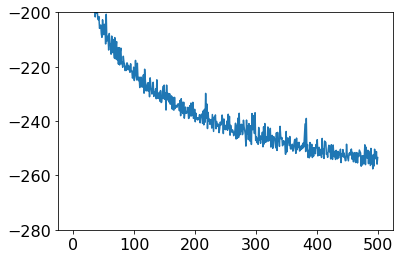

In [31]:
plt.plot(hml.history['loss'])
plt.ylim(-280, -200)

Std z = 0.99922574


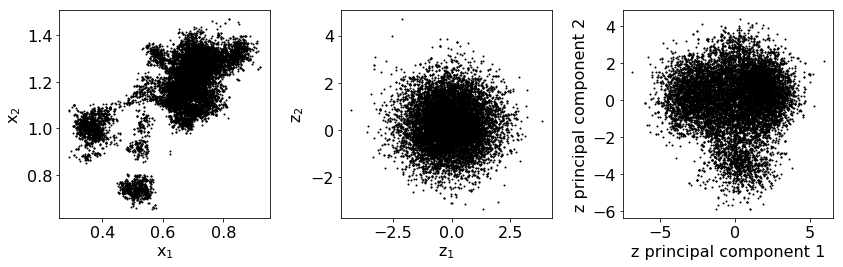

In [32]:
test_xz_projection(network.Txz, [xtrain])
print('Std z =', network.std_z(xtrain))

Traj  0 Fraction of low energies:  0.7607
Traj  0 Minimum energy:  146.23960781097412
Traj  1 Fraction of low energies:  0.7607
Traj  1 Minimum energy:  146.23960781097412


(<matplotlib.figure.Figure at 0x182eac6898>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x182eab9f60>,
       dtype=object))

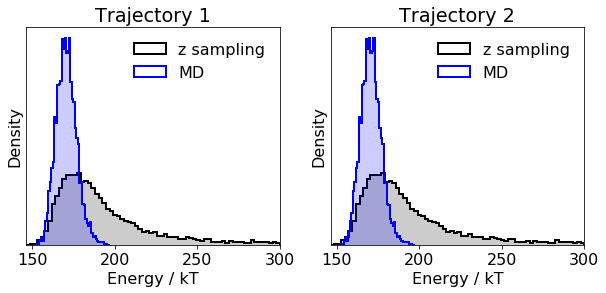

In [33]:
sz, sx, Ez, Ex, logw = network.sample(temperature=1.0, nsample=10000)
test_generate_x(mm_cyc9, [xtrain, xtrain], Ex, colors=['blue', 'blue'], max_energy=300)

In [463]:
#network.save('/../local_data/hydrocarbon_cyc9/network_ML_longer.pkl')

In [464]:
hkl = network.train_flexible(xtrain, lr=0.0001, epochs=5000, weight_ML=1.0, weight_KL=0.01, 
                             high_energy=10000, max_energy=1e15, explore=1.0)

Epoch 0/5000 loss -231.7352 output_z_loss -239.8227 output_x_loss 808.7473 
Epoch 1/5000 loss -236.3467 output_z_loss -245.1478 output_x_loss 880.1062 
Epoch 2/5000 loss -236.4774 output_z_loss -245.3374 output_x_loss 885.9996 
Epoch 3/5000 loss -236.7503 output_z_loss -246.3789 output_x_loss 962.8602 
Epoch 4/5000 loss -235.7328 output_z_loss -245.6935 output_x_loss 996.0668 
Epoch 5/5000 loss -239.3676 output_z_loss -247.5549 output_x_loss 818.7397 
Epoch 6/5000 loss -237.1246 output_z_loss -246.8727 output_x_loss 974.8091 
Epoch 7/5000 loss -237.9859 output_z_loss -246.4470 output_x_loss 846.1078 
Epoch 8/5000 loss -239.7577 output_z_loss -247.7325 output_x_loss 797.4757 
Epoch 9/5000 loss -240.1423 output_z_loss -248.1433 output_x_loss 800.1024 
Epoch 10/5000 loss -238.7404 output_z_loss -248.0604 output_x_loss 932.0002 
Epoch 11/5000 loss -239.1887 output_z_loss -247.8013 output_x_loss 861.2650 
Epoch 12/5000 loss -240.4595 output_z_loss -247.8144 output_x_loss 735.4930 
Epoch 13/

Epoch 107/5000 loss -241.1671 output_z_loss -249.2094 output_x_loss 804.2292 
Epoch 108/5000 loss -241.1968 output_z_loss -249.4432 output_x_loss 824.6349 
Epoch 109/5000 loss -242.1771 output_z_loss -249.5936 output_x_loss 741.6505 
Epoch 110/5000 loss -240.9801 output_z_loss -248.8355 output_x_loss 785.5423 
Epoch 111/5000 loss -242.1053 output_z_loss -249.3659 output_x_loss 726.0667 
Epoch 112/5000 loss -241.8769 output_z_loss -249.2588 output_x_loss 738.1881 
Epoch 113/5000 loss -241.0842 output_z_loss -249.9139 output_x_loss 882.9705 
Epoch 114/5000 loss -242.0349 output_z_loss -249.4055 output_x_loss 737.0605 
Epoch 115/5000 loss -242.2062 output_z_loss -249.4568 output_x_loss 725.0607 
Epoch 116/5000 loss -242.2208 output_z_loss -249.9602 output_x_loss 773.9435 
Epoch 117/5000 loss -242.2592 output_z_loss -249.6371 output_x_loss 737.7899 
Epoch 118/5000 loss -242.4200 output_z_loss -249.6747 output_x_loss 725.4633 
Epoch 119/5000 loss -241.8136 output_z_loss -249.3575 output_x_l

Epoch 213/5000 loss -242.7853 output_z_loss -249.4726 output_x_loss 668.7313 
Epoch 214/5000 loss -241.7261 output_z_loss -249.8131 output_x_loss 808.6942 
Epoch 215/5000 loss -242.3671 output_z_loss -249.2350 output_x_loss 686.7938 
Epoch 216/5000 loss -243.3799 output_z_loss -250.1155 output_x_loss 673.5651 
Epoch 217/5000 loss -243.3178 output_z_loss -249.8715 output_x_loss 655.3692 
Epoch 218/5000 loss -242.4900 output_z_loss -249.5569 output_x_loss 706.6924 
Epoch 219/5000 loss -242.2136 output_z_loss -249.6566 output_x_loss 744.2983 
Epoch 220/5000 loss -242.6330 output_z_loss -249.9824 output_x_loss 734.9443 
Epoch 221/5000 loss -241.8655 output_z_loss -249.0162 output_x_loss 715.0745 
Epoch 222/5000 loss -242.9838 output_z_loss -249.6710 output_x_loss 668.7194 
Epoch 223/5000 loss -243.0072 output_z_loss -249.5065 output_x_loss 649.9337 
Epoch 224/5000 loss -244.2729 output_z_loss -250.7434 output_x_loss 647.0543 
Epoch 225/5000 loss -243.0141 output_z_loss -250.0257 output_x_l

Epoch 319/5000 loss -244.0461 output_z_loss -250.6683 output_x_loss 662.2158 
Epoch 320/5000 loss -244.5195 output_z_loss -250.8393 output_x_loss 631.9788 
Epoch 321/5000 loss -243.6024 output_z_loss -249.9573 output_x_loss 635.4949 
Epoch 322/5000 loss -242.3065 output_z_loss -249.4851 output_x_loss 717.8617 
Epoch 323/5000 loss -242.9773 output_z_loss -250.0093 output_x_loss 703.1963 
Epoch 324/5000 loss -242.9196 output_z_loss -250.1888 output_x_loss 726.9152 
Epoch 325/5000 loss -243.0002 output_z_loss -249.8238 output_x_loss 682.3685 
Epoch 326/5000 loss -243.4373 output_z_loss -250.0686 output_x_loss 663.1358 
Epoch 327/5000 loss -242.7725 output_z_loss -249.5074 output_x_loss 673.4924 
Epoch 328/5000 loss -242.5363 output_z_loss -249.7428 output_x_loss 720.6450 
Epoch 329/5000 loss -243.7174 output_z_loss -250.4037 output_x_loss 668.6307 
Epoch 330/5000 loss -242.6163 output_z_loss -249.3539 output_x_loss 673.7607 
Epoch 331/5000 loss -243.1103 output_z_loss -250.1460 output_x_l

Epoch 425/5000 loss -243.5746 output_z_loss -249.8062 output_x_loss 623.1560 
Epoch 426/5000 loss -243.1418 output_z_loss -250.1074 output_x_loss 696.5614 
Epoch 427/5000 loss -243.3702 output_z_loss -249.9623 output_x_loss 659.2146 
Epoch 428/5000 loss -244.9268 output_z_loss -250.9233 output_x_loss 599.6538 
Epoch 429/5000 loss -242.5832 output_z_loss -250.0628 output_x_loss 747.9607 
Epoch 430/5000 loss -242.4464 output_z_loss -249.8728 output_x_loss 742.6411 
Epoch 431/5000 loss -242.5502 output_z_loss -248.8721 output_x_loss 632.1833 
Epoch 432/5000 loss -242.8698 output_z_loss -249.6745 output_x_loss 680.4712 
Epoch 433/5000 loss -243.2609 output_z_loss -249.8174 output_x_loss 655.6444 
Epoch 434/5000 loss -243.4907 output_z_loss -250.0901 output_x_loss 659.9397 
Epoch 435/5000 loss -243.4966 output_z_loss -250.2449 output_x_loss 674.8355 
Epoch 436/5000 loss -243.4588 output_z_loss -249.9426 output_x_loss 648.3818 
Epoch 437/5000 loss -243.4433 output_z_loss -250.0455 output_x_l

Epoch 531/5000 loss -244.3451 output_z_loss -250.8870 output_x_loss 654.1921 
Epoch 532/5000 loss -243.5900 output_z_loss -250.3874 output_x_loss 679.7379 
Epoch 533/5000 loss -244.9244 output_z_loss -250.7560 output_x_loss 583.1680 
Epoch 534/5000 loss -244.3727 output_z_loss -251.1708 output_x_loss 679.8060 
Epoch 535/5000 loss -244.9579 output_z_loss -251.0496 output_x_loss 609.1634 
Epoch 536/5000 loss -243.4274 output_z_loss -250.0750 output_x_loss 664.7593 
Epoch 537/5000 loss -242.7476 output_z_loss -249.6925 output_x_loss 694.4945 
Epoch 538/5000 loss -244.0093 output_z_loss -250.4696 output_x_loss 646.0274 
Epoch 539/5000 loss -242.7456 output_z_loss -249.3551 output_x_loss 660.9491 
Epoch 540/5000 loss -243.3183 output_z_loss -250.4749 output_x_loss 715.6624 
Epoch 541/5000 loss -243.3598 output_z_loss -250.5456 output_x_loss 718.5798 
Epoch 542/5000 loss -243.9054 output_z_loss -250.2776 output_x_loss 637.2252 
Epoch 543/5000 loss -243.7713 output_z_loss -250.0968 output_x_l

Epoch 637/5000 loss -244.0539 output_z_loss -250.2494 output_x_loss 619.5510 
Epoch 638/5000 loss -243.6904 output_z_loss -250.1886 output_x_loss 649.8160 
Epoch 639/5000 loss -244.8075 output_z_loss -251.0558 output_x_loss 624.8267 
Epoch 640/5000 loss -244.0640 output_z_loss -250.5160 output_x_loss 645.1952 
Epoch 641/5000 loss -243.6058 output_z_loss -250.6140 output_x_loss 700.8239 
Epoch 642/5000 loss -244.2224 output_z_loss -251.1758 output_x_loss 695.3445 
Epoch 643/5000 loss -244.5573 output_z_loss -250.9219 output_x_loss 636.4542 
Epoch 644/5000 loss -245.1476 output_z_loss -251.3495 output_x_loss 620.1851 
Epoch 645/5000 loss -243.7861 output_z_loss -250.3426 output_x_loss 655.6486 
Epoch 646/5000 loss -244.3026 output_z_loss -250.6560 output_x_loss 635.3468 
Epoch 647/5000 loss -244.6656 output_z_loss -251.3938 output_x_loss 672.8285 
Epoch 648/5000 loss -243.4588 output_z_loss -250.2803 output_x_loss 682.1498 
Epoch 649/5000 loss -244.2672 output_z_loss -250.5798 output_x_l

Epoch 743/5000 loss -244.6708 output_z_loss -250.6784 output_x_loss 600.7628 
Epoch 744/5000 loss -245.0923 output_z_loss -251.1298 output_x_loss 603.7458 
Epoch 745/5000 loss -245.2938 output_z_loss -251.3611 output_x_loss 606.7328 
Epoch 746/5000 loss -243.4294 output_z_loss -250.6369 output_x_loss 720.7437 
Epoch 747/5000 loss -244.7703 output_z_loss -251.0563 output_x_loss 628.6028 
Epoch 748/5000 loss -243.8958 output_z_loss -251.3244 output_x_loss 742.8553 
Epoch 749/5000 loss -244.4690 output_z_loss -250.4772 output_x_loss 600.8265 
Epoch 750/5000 loss -244.4048 output_z_loss -250.6303 output_x_loss 622.5516 
Epoch 751/5000 loss -244.1472 output_z_loss -250.2285 output_x_loss 608.1208 
Epoch 752/5000 loss -244.2739 output_z_loss -250.8254 output_x_loss 655.1517 
Epoch 753/5000 loss -243.3862 output_z_loss -250.3969 output_x_loss 701.0650 
Epoch 754/5000 loss -243.2122 output_z_loss -250.1162 output_x_loss 690.4065 
Epoch 755/5000 loss -244.5938 output_z_loss -250.9399 output_x_l

Epoch 849/5000 loss -243.7313 output_z_loss -250.6210 output_x_loss 688.9746 
Epoch 850/5000 loss -244.3489 output_z_loss -250.5891 output_x_loss 624.0225 
Epoch 851/5000 loss -244.2708 output_z_loss -250.4922 output_x_loss 622.1414 
Epoch 852/5000 loss -245.3661 output_z_loss -251.1583 output_x_loss 579.2203 
Epoch 853/5000 loss -245.1432 output_z_loss -251.1318 output_x_loss 598.8536 
Epoch 854/5000 loss -245.6152 output_z_loss -251.6950 output_x_loss 607.9793 
Epoch 855/5000 loss -244.6018 output_z_loss -250.6702 output_x_loss 606.8477 
Epoch 856/5000 loss -243.6301 output_z_loss -250.0704 output_x_loss 644.0250 
Epoch 857/5000 loss -244.6052 output_z_loss -250.7660 output_x_loss 616.0812 
Epoch 858/5000 loss -244.1709 output_z_loss -250.6536 output_x_loss 648.2649 
Epoch 859/5000 loss -245.4905 output_z_loss -250.9547 output_x_loss 546.4273 
Epoch 860/5000 loss -243.6390 output_z_loss -250.5742 output_x_loss 693.5125 
Epoch 861/5000 loss -244.8602 output_z_loss -250.7056 output_x_l

Epoch 955/5000 loss -244.8497 output_z_loss -251.1428 output_x_loss 629.3099 
Epoch 956/5000 loss -244.7766 output_z_loss -251.8099 output_x_loss 703.3297 
Epoch 957/5000 loss -243.5242 output_z_loss -250.9782 output_x_loss 745.4047 
Epoch 958/5000 loss -244.1557 output_z_loss -251.1472 output_x_loss 699.1454 
Epoch 959/5000 loss -244.1237 output_z_loss -250.7613 output_x_loss 663.7575 
Epoch 960/5000 loss -245.4365 output_z_loss -251.6874 output_x_loss 625.0896 
Epoch 961/5000 loss -245.1056 output_z_loss -251.2176 output_x_loss 611.1983 
Epoch 962/5000 loss -245.4456 output_z_loss -251.3094 output_x_loss 586.3794 
Epoch 963/5000 loss -245.2455 output_z_loss -251.3924 output_x_loss 614.6944 
Epoch 964/5000 loss -245.7538 output_z_loss -251.8812 output_x_loss 612.7483 
Epoch 965/5000 loss -245.2024 output_z_loss -251.6194 output_x_loss 641.6957 
Epoch 966/5000 loss -244.6340 output_z_loss -250.6623 output_x_loss 602.8281 
Epoch 967/5000 loss -244.9670 output_z_loss -251.0527 output_x_l

Epoch 1060/5000 loss -244.7252 output_z_loss -250.9981 output_x_loss 627.2946 
Epoch 1061/5000 loss -245.0267 output_z_loss -250.9396 output_x_loss 591.2870 
Epoch 1062/5000 loss -246.1202 output_z_loss -251.6098 output_x_loss 548.9586 
Epoch 1063/5000 loss -244.9126 output_z_loss -251.0949 output_x_loss 618.2305 
Epoch 1064/5000 loss -245.2863 output_z_loss -251.5825 output_x_loss 629.6255 
Epoch 1065/5000 loss -245.2595 output_z_loss -251.5531 output_x_loss 629.3613 
Epoch 1066/5000 loss -244.6445 output_z_loss -250.6905 output_x_loss 604.5988 
Epoch 1067/5000 loss -244.6252 output_z_loss -251.2714 output_x_loss 664.6227 
Epoch 1068/5000 loss -244.4807 output_z_loss -250.9348 output_x_loss 645.4133 
Epoch 1069/5000 loss -245.2036 output_z_loss -251.2314 output_x_loss 602.7750 
Epoch 1070/5000 loss -243.4874 output_z_loss -249.9933 output_x_loss 650.5854 
Epoch 1071/5000 loss -244.7721 output_z_loss -251.3690 output_x_loss 659.6988 
Epoch 1072/5000 loss -244.7491 output_z_loss -250.83

Epoch 1164/5000 loss -245.3550 output_z_loss -251.0278 output_x_loss 567.2762 
Epoch 1165/5000 loss -245.0486 output_z_loss -251.5087 output_x_loss 646.0094 
Epoch 1166/5000 loss -245.3279 output_z_loss -251.5254 output_x_loss 619.7461 
Epoch 1167/5000 loss -244.5998 output_z_loss -250.6529 output_x_loss 605.3135 
Epoch 1168/5000 loss -244.4742 output_z_loss -250.7664 output_x_loss 629.2188 
Epoch 1169/5000 loss -244.4554 output_z_loss -250.6174 output_x_loss 616.1960 
Epoch 1170/5000 loss -245.4793 output_z_loss -251.4733 output_x_loss 599.3934 
Epoch 1171/5000 loss -246.2205 output_z_loss -252.0311 output_x_loss 581.0577 
Epoch 1172/5000 loss -245.5827 output_z_loss -251.7872 output_x_loss 620.4431 
Epoch 1173/5000 loss -245.3146 output_z_loss -251.2400 output_x_loss 592.5353 
Epoch 1174/5000 loss -245.6671 output_z_loss -251.9265 output_x_loss 625.9362 
Epoch 1175/5000 loss -245.1450 output_z_loss -251.6839 output_x_loss 653.8955 
Epoch 1176/5000 loss -245.0418 output_z_loss -251.47

Epoch 1268/5000 loss -245.5350 output_z_loss -251.2345 output_x_loss 569.9489 
Epoch 1269/5000 loss -245.1963 output_z_loss -251.9626 output_x_loss 676.6360 
Epoch 1270/5000 loss -246.1302 output_z_loss -251.7934 output_x_loss 566.3146 
Epoch 1271/5000 loss -245.5089 output_z_loss -251.4421 output_x_loss 593.3201 
Epoch 1272/5000 loss -245.4047 output_z_loss -251.0471 output_x_loss 564.2407 
Epoch 1273/5000 loss -245.4778 output_z_loss -251.3162 output_x_loss 583.8450 
Epoch 1274/5000 loss -244.9700 output_z_loss -251.2085 output_x_loss 623.8553 
Epoch 1275/5000 loss -245.6584 output_z_loss -251.7704 output_x_loss 611.2079 
Epoch 1276/5000 loss -244.7909 output_z_loss -250.5798 output_x_loss 578.8973 
Epoch 1277/5000 loss -244.5908 output_z_loss -251.0658 output_x_loss 647.5072 
Epoch 1278/5000 loss -245.5738 output_z_loss -250.6593 output_x_loss 508.5503 
Epoch 1279/5000 loss -245.1297 output_z_loss -251.3837 output_x_loss 625.4039 
Epoch 1280/5000 loss -244.7854 output_z_loss -251.26

Epoch 1372/5000 loss -245.3707 output_z_loss -251.3607 output_x_loss 599.0028 
Epoch 1373/5000 loss -245.2373 output_z_loss -251.2838 output_x_loss 604.6591 
Epoch 1374/5000 loss -245.5042 output_z_loss -251.2948 output_x_loss 579.0542 
Epoch 1375/5000 loss -245.5681 output_z_loss -251.7308 output_x_loss 616.2742 
Epoch 1376/5000 loss -245.6402 output_z_loss -251.7686 output_x_loss 612.8365 
Epoch 1377/5000 loss -244.5436 output_z_loss -250.6581 output_x_loss 611.4438 
Epoch 1378/5000 loss -245.3254 output_z_loss -251.3824 output_x_loss 605.6951 
Epoch 1379/5000 loss -245.2115 output_z_loss -251.3057 output_x_loss 609.4192 
Epoch 1380/5000 loss -245.6240 output_z_loss -251.4071 output_x_loss 578.3098 
Epoch 1381/5000 loss -246.6366 output_z_loss -252.1053 output_x_loss 546.8667 
Epoch 1382/5000 loss -245.0517 output_z_loss -251.3736 output_x_loss 632.1895 
Epoch 1383/5000 loss -245.5432 output_z_loss -251.6412 output_x_loss 609.7957 
Epoch 1384/5000 loss -245.1274 output_z_loss -250.87

Epoch 1476/5000 loss -245.8331 output_z_loss -251.9705 output_x_loss 613.7413 
Epoch 1477/5000 loss -245.6482 output_z_loss -251.8711 output_x_loss 622.2848 
Epoch 1478/5000 loss -245.8399 output_z_loss -252.2053 output_x_loss 636.5481 
Epoch 1479/5000 loss -244.9324 output_z_loss -250.8596 output_x_loss 592.7211 
Epoch 1480/5000 loss -244.9471 output_z_loss -251.0867 output_x_loss 613.9555 
Epoch 1481/5000 loss -245.3135 output_z_loss -251.4429 output_x_loss 612.9393 
Epoch 1482/5000 loss -245.6829 output_z_loss -251.5460 output_x_loss 586.3105 
Epoch 1483/5000 loss -245.9162 output_z_loss -251.8408 output_x_loss 592.4513 
Epoch 1484/5000 loss -245.9745 output_z_loss -251.4894 output_x_loss 551.4944 
Epoch 1485/5000 loss -245.2788 output_z_loss -251.6200 output_x_loss 634.1239 
Epoch 1486/5000 loss -245.7677 output_z_loss -251.7988 output_x_loss 603.1074 
Epoch 1487/5000 loss -245.8909 output_z_loss -252.2325 output_x_loss 634.1545 
Epoch 1488/5000 loss -246.2104 output_z_loss -252.02

Epoch 1580/5000 loss -246.1806 output_z_loss -252.1707 output_x_loss 599.0136 
Epoch 1581/5000 loss -246.2347 output_z_loss -251.9677 output_x_loss 573.3024 
Epoch 1582/5000 loss -245.9994 output_z_loss -251.9889 output_x_loss 598.9531 
Epoch 1583/5000 loss -245.5842 output_z_loss -251.2715 output_x_loss 568.7280 
Epoch 1584/5000 loss -246.4096 output_z_loss -252.1217 output_x_loss 571.2140 
Epoch 1585/5000 loss -245.3836 output_z_loss -251.9146 output_x_loss 653.1000 
Epoch 1586/5000 loss -245.6795 output_z_loss -251.5220 output_x_loss 584.2569 
Epoch 1587/5000 loss -245.9354 output_z_loss -251.8028 output_x_loss 586.7379 
Epoch 1588/5000 loss -246.2660 output_z_loss -251.9118 output_x_loss 564.5763 
Epoch 1589/5000 loss -246.4019 output_z_loss -252.5078 output_x_loss 610.5903 
Epoch 1590/5000 loss -245.6170 output_z_loss -251.6315 output_x_loss 601.4541 
Epoch 1591/5000 loss -245.8940 output_z_loss -251.6066 output_x_loss 571.2645 
Epoch 1592/5000 loss -246.5272 output_z_loss -251.99

Epoch 1684/5000 loss -245.5128 output_z_loss -251.7057 output_x_loss 619.2900 
Epoch 1685/5000 loss -245.2448 output_z_loss -251.7215 output_x_loss 647.6757 
Epoch 1686/5000 loss -245.7452 output_z_loss -251.8872 output_x_loss 614.2019 
Epoch 1687/5000 loss -245.2731 output_z_loss -251.4819 output_x_loss 620.8820 
Epoch 1688/5000 loss -246.1637 output_z_loss -252.2555 output_x_loss 609.1780 
Epoch 1689/5000 loss -246.2390 output_z_loss -251.9759 output_x_loss 573.6951 
Epoch 1690/5000 loss -245.7294 output_z_loss -251.8861 output_x_loss 615.6730 
Epoch 1691/5000 loss -245.7991 output_z_loss -251.6447 output_x_loss 584.5540 
Epoch 1692/5000 loss -246.0018 output_z_loss -252.2230 output_x_loss 622.1268 
Epoch 1693/5000 loss -245.5904 output_z_loss -251.6848 output_x_loss 609.4393 
Epoch 1694/5000 loss -245.7680 output_z_loss -252.2101 output_x_loss 644.2101 
Epoch 1695/5000 loss -245.3070 output_z_loss -251.4911 output_x_loss 618.4080 
Epoch 1696/5000 loss -245.3179 output_z_loss -251.36

Epoch 1788/5000 loss -246.1000 output_z_loss -252.0386 output_x_loss 593.8589 
Epoch 1789/5000 loss -246.1540 output_z_loss -252.3731 output_x_loss 621.9075 
Epoch 1790/5000 loss -246.2758 output_z_loss -252.2821 output_x_loss 600.6293 
Epoch 1791/5000 loss -245.8682 output_z_loss -251.4941 output_x_loss 562.5878 
Epoch 1792/5000 loss -246.1907 output_z_loss -252.2296 output_x_loss 603.8831 
Epoch 1793/5000 loss -245.4785 output_z_loss -251.9635 output_x_loss 648.4978 
Epoch 1794/5000 loss -247.1663 output_z_loss -252.7849 output_x_loss 561.8584 
Epoch 1795/5000 loss -246.2240 output_z_loss -252.0769 output_x_loss 585.2844 
Epoch 1796/5000 loss -246.4546 output_z_loss -251.9570 output_x_loss 550.2411 
Epoch 1797/5000 loss -246.0641 output_z_loss -252.0142 output_x_loss 595.0043 
Epoch 1798/5000 loss -246.3303 output_z_loss -252.1540 output_x_loss 582.3662 
Epoch 1799/5000 loss -247.1693 output_z_loss -252.5313 output_x_loss 536.2003 
Epoch 1800/5000 loss -245.4801 output_z_loss -251.49

Epoch 1892/5000 loss -245.9365 output_z_loss -251.6003 output_x_loss 566.3809 
Epoch 1893/5000 loss -246.3786 output_z_loss -252.2482 output_x_loss 586.9620 
Epoch 1894/5000 loss -245.8765 output_z_loss -252.2818 output_x_loss 640.5229 
Epoch 1895/5000 loss -246.0241 output_z_loss -251.5534 output_x_loss 552.9325 
Epoch 1896/5000 loss -245.6832 output_z_loss -251.6746 output_x_loss 599.1400 
Epoch 1897/5000 loss -246.7263 output_z_loss -253.0181 output_x_loss 629.1768 
Epoch 1898/5000 loss -246.0183 output_z_loss -251.9747 output_x_loss 595.6450 
Epoch 1899/5000 loss -245.9151 output_z_loss -251.7180 output_x_loss 580.2886 
Epoch 1900/5000 loss -246.7489 output_z_loss -252.8157 output_x_loss 606.6770 
Epoch 1901/5000 loss -246.3830 output_z_loss -252.3881 output_x_loss 600.5162 
Epoch 1902/5000 loss -245.8857 output_z_loss -251.3815 output_x_loss 549.5839 
Epoch 1903/5000 loss -247.1727 output_z_loss -252.8969 output_x_loss 572.4160 
Epoch 1904/5000 loss -245.9539 output_z_loss -251.95

Epoch 1996/5000 loss -247.2097 output_z_loss -252.9927 output_x_loss 578.3042 
Epoch 1997/5000 loss -245.3815 output_z_loss -251.3901 output_x_loss 600.8687 
Epoch 1998/5000 loss -246.1837 output_z_loss -251.8111 output_x_loss 562.7411 
Epoch 1999/5000 loss -245.9234 output_z_loss -251.7856 output_x_loss 586.2192 
Epoch 2000/5000 loss -246.2803 output_z_loss -251.9475 output_x_loss 566.7192 
Epoch 2001/5000 loss -246.0821 output_z_loss -252.2500 output_x_loss 616.7921 
Epoch 2002/5000 loss -246.7094 output_z_loss -252.7151 output_x_loss 600.5703 
Epoch 2003/5000 loss -246.8575 output_z_loss -252.4210 output_x_loss 556.3474 
Epoch 2004/5000 loss -246.9470 output_z_loss -252.7764 output_x_loss 582.9423 
Epoch 2005/5000 loss -245.6662 output_z_loss -251.9103 output_x_loss 624.4081 
Epoch 2006/5000 loss -246.9836 output_z_loss -252.9305 output_x_loss 594.6938 
Epoch 2007/5000 loss -246.3741 output_z_loss -252.2621 output_x_loss 588.7966 
Epoch 2008/5000 loss -246.7935 output_z_loss -252.34

Epoch 2100/5000 loss -246.3636 output_z_loss -252.2066 output_x_loss 584.3048 
Epoch 2101/5000 loss -245.7368 output_z_loss -251.8245 output_x_loss 608.7755 
Epoch 2102/5000 loss -246.5360 output_z_loss -252.4810 output_x_loss 594.5004 
Epoch 2103/5000 loss -246.2764 output_z_loss -252.4634 output_x_loss 618.7012 
Epoch 2104/5000 loss -246.1671 output_z_loss -252.5826 output_x_loss 641.5458 
Epoch 2105/5000 loss -246.6364 output_z_loss -253.0307 output_x_loss 639.4218 
Epoch 2106/5000 loss -246.8504 output_z_loss -252.2137 output_x_loss 536.3258 
Epoch 2107/5000 loss -246.5357 output_z_loss -252.5309 output_x_loss 599.5243 
Epoch 2108/5000 loss -247.1560 output_z_loss -252.7596 output_x_loss 560.3668 
Epoch 2109/5000 loss -246.5852 output_z_loss -252.3327 output_x_loss 574.7519 
Epoch 2110/5000 loss -246.3583 output_z_loss -252.6798 output_x_loss 632.1498 
Epoch 2111/5000 loss -246.7350 output_z_loss -252.1119 output_x_loss 537.6942 
Epoch 2112/5000 loss -246.2095 output_z_loss -252.54

Epoch 2204/5000 loss -246.1794 output_z_loss -252.1047 output_x_loss 592.5333 
Epoch 2205/5000 loss -246.2033 output_z_loss -252.7794 output_x_loss 657.6080 
Epoch 2206/5000 loss -246.8038 output_z_loss -253.0322 output_x_loss 622.8399 
Epoch 2207/5000 loss -246.1767 output_z_loss -252.5470 output_x_loss 637.0341 
Epoch 2208/5000 loss -247.1249 output_z_loss -253.0110 output_x_loss 588.6077 
Epoch 2209/5000 loss -246.7854 output_z_loss -252.7916 output_x_loss 600.6201 
Epoch 2210/5000 loss -246.8612 output_z_loss -252.7993 output_x_loss 593.8151 
Epoch 2211/5000 loss -246.3428 output_z_loss -252.2697 output_x_loss 592.6884 
Epoch 2212/5000 loss -246.8593 output_z_loss -252.9453 output_x_loss 608.5994 
Epoch 2213/5000 loss -247.1381 output_z_loss -252.5820 output_x_loss 544.3975 
Epoch 2214/5000 loss -246.0894 output_z_loss -252.0483 output_x_loss 595.8811 
Epoch 2215/5000 loss -244.8174 output_z_loss -251.0557 output_x_loss 623.8316 
Epoch 2216/5000 loss -247.0389 output_z_loss -252.52

Epoch 2308/5000 loss -246.7524 output_z_loss -252.9890 output_x_loss 623.6628 
Epoch 2309/5000 loss -246.1015 output_z_loss -252.1722 output_x_loss 607.0760 
Epoch 2310/5000 loss -245.7042 output_z_loss -251.9860 output_x_loss 628.1826 
Epoch 2311/5000 loss -246.6883 output_z_loss -252.6788 output_x_loss 599.0527 
Epoch 2312/5000 loss -246.8097 output_z_loss -252.4692 output_x_loss 565.9513 
Epoch 2313/5000 loss -246.1303 output_z_loss -252.5104 output_x_loss 638.0099 
Epoch 2314/5000 loss -246.4628 output_z_loss -252.5939 output_x_loss 613.1089 
Epoch 2315/5000 loss -246.6331 output_z_loss -252.2285 output_x_loss 559.5432 
Epoch 2316/5000 loss -246.9189 output_z_loss -252.7310 output_x_loss 581.2056 
Epoch 2317/5000 loss -245.3082 output_z_loss -251.2993 output_x_loss 599.1186 
Epoch 2318/5000 loss -246.9863 output_z_loss -252.9045 output_x_loss 591.8216 
Epoch 2319/5000 loss -246.5702 output_z_loss -252.4682 output_x_loss 589.7947 
Epoch 2320/5000 loss -246.9347 output_z_loss -252.74

Epoch 2412/5000 loss -246.5195 output_z_loss -252.7606 output_x_loss 624.1078 
Epoch 2413/5000 loss -246.5411 output_z_loss -252.2368 output_x_loss 569.5649 
Epoch 2414/5000 loss -245.7912 output_z_loss -251.7238 output_x_loss 593.2563 
Epoch 2415/5000 loss -246.2141 output_z_loss -252.1124 output_x_loss 589.8256 
Epoch 2416/5000 loss -246.8108 output_z_loss -252.7895 output_x_loss 597.8639 
Epoch 2417/5000 loss -246.5881 output_z_loss -252.7071 output_x_loss 611.8951 
Epoch 2418/5000 loss -246.8060 output_z_loss -252.6899 output_x_loss 588.3923 
Epoch 2419/5000 loss -247.6581 output_z_loss -253.3574 output_x_loss 569.9213 
Epoch 2420/5000 loss -246.5482 output_z_loss -252.2499 output_x_loss 570.1728 
Epoch 2421/5000 loss -245.6853 output_z_loss -251.8794 output_x_loss 619.4067 
Epoch 2422/5000 loss -247.1766 output_z_loss -252.6983 output_x_loss 552.1677 
Epoch 2423/5000 loss -246.3964 output_z_loss -252.8620 output_x_loss 646.5593 
Epoch 2424/5000 loss -246.9795 output_z_loss -252.69

Epoch 2516/5000 loss -246.8951 output_z_loss -252.7714 output_x_loss 587.6239 
Epoch 2517/5000 loss -247.4079 output_z_loss -252.8203 output_x_loss 541.2391 
Epoch 2518/5000 loss -246.3555 output_z_loss -252.3425 output_x_loss 598.6996 
Epoch 2519/5000 loss -246.1135 output_z_loss -252.1550 output_x_loss 604.1556 
Epoch 2520/5000 loss -247.1839 output_z_loss -253.3820 output_x_loss 619.8178 
Epoch 2521/5000 loss -246.1633 output_z_loss -251.9385 output_x_loss 577.5176 
Epoch 2522/5000 loss -246.6069 output_z_loss -252.4556 output_x_loss 584.8720 
Epoch 2523/5000 loss -246.7745 output_z_loss -252.4800 output_x_loss 570.5578 
Epoch 2524/5000 loss -245.9763 output_z_loss -251.9492 output_x_loss 597.2888 
Epoch 2525/5000 loss -247.2399 output_z_loss -252.8313 output_x_loss 559.1360 
Epoch 2526/5000 loss -246.1912 output_z_loss -251.9847 output_x_loss 579.3484 
Epoch 2527/5000 loss -246.4770 output_z_loss -252.3259 output_x_loss 584.8911 
Epoch 2528/5000 loss -246.3514 output_z_loss -251.85

Epoch 2620/5000 loss -247.3641 output_z_loss -252.9891 output_x_loss 562.5005 
Epoch 2621/5000 loss -247.1008 output_z_loss -252.9804 output_x_loss 587.9602 
Epoch 2622/5000 loss -246.8119 output_z_loss -252.2994 output_x_loss 548.7493 
Epoch 2623/5000 loss -247.7576 output_z_loss -253.3153 output_x_loss 555.7697 
Epoch 2624/5000 loss -247.0152 output_z_loss -253.1263 output_x_loss 611.1105 
Epoch 2625/5000 loss -247.1296 output_z_loss -252.5574 output_x_loss 542.7816 
Epoch 2626/5000 loss -246.4325 output_z_loss -252.4535 output_x_loss 602.0968 
Epoch 2627/5000 loss -247.4041 output_z_loss -253.1844 output_x_loss 578.0380 
Epoch 2628/5000 loss -246.9118 output_z_loss -252.6127 output_x_loss 570.0837 
Epoch 2629/5000 loss -246.4242 output_z_loss -252.5621 output_x_loss 613.7881 
Epoch 2630/5000 loss -247.4526 output_z_loss -252.9327 output_x_loss 548.0127 
Epoch 2631/5000 loss -247.2542 output_z_loss -252.6633 output_x_loss 540.9097 
Epoch 2632/5000 loss -247.2973 output_z_loss -252.99

Epoch 2724/5000 loss -247.5390 output_z_loss -252.8830 output_x_loss 534.4042 
Epoch 2725/5000 loss -247.1376 output_z_loss -253.1105 output_x_loss 597.2874 
Epoch 2726/5000 loss -245.9662 output_z_loss -252.2275 output_x_loss 626.1324 
Epoch 2727/5000 loss -246.3691 output_z_loss -252.4286 output_x_loss 605.9503 
Epoch 2728/5000 loss -246.6497 output_z_loss -252.6758 output_x_loss 602.6110 
Epoch 2729/5000 loss -248.1966 output_z_loss -253.3683 output_x_loss 517.1630 
Epoch 2730/5000 loss -246.9258 output_z_loss -252.5364 output_x_loss 561.0580 
Epoch 2731/5000 loss -246.3108 output_z_loss -252.4759 output_x_loss 616.5145 
Epoch 2732/5000 loss -247.0169 output_z_loss -252.7883 output_x_loss 577.1392 
Epoch 2733/5000 loss -247.9547 output_z_loss -253.4722 output_x_loss 551.7566 
Epoch 2734/5000 loss -245.6825 output_z_loss -252.1985 output_x_loss 651.6060 
Epoch 2735/5000 loss -247.0862 output_z_loss -252.9970 output_x_loss 591.0770 
Epoch 2736/5000 loss -246.2602 output_z_loss -251.91

Epoch 2828/5000 loss -246.5811 output_z_loss -252.1451 output_x_loss 556.3916 
Epoch 2829/5000 loss -246.7762 output_z_loss -253.0651 output_x_loss 628.8901 
Epoch 2830/5000 loss -248.4343 output_z_loss -253.6323 output_x_loss 519.7933 
Epoch 2831/5000 loss -245.8755 output_z_loss -252.4469 output_x_loss 657.1357 
Epoch 2832/5000 loss -247.4753 output_z_loss -253.1954 output_x_loss 572.0132 
Epoch 2833/5000 loss -247.6982 output_z_loss -253.3247 output_x_loss 562.6525 
Epoch 2834/5000 loss -246.2814 output_z_loss -252.2938 output_x_loss 601.2360 
Epoch 2835/5000 loss -245.9063 output_z_loss -252.0746 output_x_loss 616.8301 
Epoch 2836/5000 loss -247.2671 output_z_loss -253.1046 output_x_loss 583.7480 
Epoch 2837/5000 loss -246.2334 output_z_loss -252.1630 output_x_loss 592.9608 
Epoch 2838/5000 loss -247.4955 output_z_loss -253.0046 output_x_loss 550.9069 
Epoch 2839/5000 loss -246.9595 output_z_loss -252.6548 output_x_loss 569.5305 
Epoch 2840/5000 loss -247.0646 output_z_loss -253.01

Epoch 2932/5000 loss -247.4658 output_z_loss -253.0420 output_x_loss 557.6153 
Epoch 2933/5000 loss -247.4742 output_z_loss -252.6601 output_x_loss 518.5901 
Epoch 2934/5000 loss -246.9789 output_z_loss -252.9101 output_x_loss 593.1250 
Epoch 2935/5000 loss -247.2640 output_z_loss -253.0014 output_x_loss 573.7379 
Epoch 2936/5000 loss -246.6331 output_z_loss -252.4604 output_x_loss 582.7264 
Epoch 2937/5000 loss -247.1715 output_z_loss -252.7713 output_x_loss 559.9833 
Epoch 2938/5000 loss -247.1441 output_z_loss -253.6826 output_x_loss 653.8481 
Epoch 2939/5000 loss -247.2388 output_z_loss -253.0470 output_x_loss 580.8123 
Epoch 2940/5000 loss -247.1034 output_z_loss -253.0498 output_x_loss 594.6404 
Epoch 2941/5000 loss -246.7499 output_z_loss -251.8984 output_x_loss 514.8450 
Epoch 2942/5000 loss -247.6086 output_z_loss -252.6880 output_x_loss 507.9394 
Epoch 2943/5000 loss -247.2988 output_z_loss -252.7509 output_x_loss 545.2100 
Epoch 2944/5000 loss -246.8128 output_z_loss -252.95

Epoch 3036/5000 loss -246.1689 output_z_loss -252.6006 output_x_loss 643.1715 
Epoch 3037/5000 loss -247.1032 output_z_loss -252.9193 output_x_loss 581.6105 
Epoch 3038/5000 loss -248.4795 output_z_loss -253.6685 output_x_loss 518.9049 
Epoch 3039/5000 loss -247.4346 output_z_loss -252.9644 output_x_loss 552.9813 
Epoch 3040/5000 loss -248.2521 output_z_loss -254.0296 output_x_loss 577.7469 
Epoch 3041/5000 loss -246.9302 output_z_loss -253.1257 output_x_loss 619.5565 
Epoch 3042/5000 loss -247.7208 output_z_loss -253.1966 output_x_loss 547.5848 
Epoch 3043/5000 loss -247.4244 output_z_loss -253.0073 output_x_loss 558.2925 
Epoch 3044/5000 loss -247.5854 output_z_loss -253.3630 output_x_loss 577.7614 
Epoch 3045/5000 loss -248.5623 output_z_loss -253.8174 output_x_loss 525.5098 
Epoch 3046/5000 loss -246.6088 output_z_loss -252.4201 output_x_loss 581.1324 
Epoch 3047/5000 loss -247.7514 output_z_loss -253.6161 output_x_loss 586.4751 
Epoch 3048/5000 loss -247.1297 output_z_loss -252.93

Epoch 3140/5000 loss -246.9892 output_z_loss -252.6674 output_x_loss 567.8130 
Epoch 3141/5000 loss -246.7581 output_z_loss -252.5756 output_x_loss 581.7577 
Epoch 3142/5000 loss -248.4777 output_z_loss -253.7508 output_x_loss 527.3140 
Epoch 3143/5000 loss -246.9260 output_z_loss -252.5074 output_x_loss 558.1456 
Epoch 3144/5000 loss -247.5491 output_z_loss -253.0487 output_x_loss 549.9544 
Epoch 3145/5000 loss -247.2161 output_z_loss -253.0727 output_x_loss 585.6611 
Epoch 3146/5000 loss -247.3454 output_z_loss -253.0754 output_x_loss 572.9999 
Epoch 3147/5000 loss -247.3053 output_z_loss -252.9706 output_x_loss 566.5320 
Epoch 3148/5000 loss -247.2834 output_z_loss -252.9484 output_x_loss 566.4985 
Epoch 3149/5000 loss -247.2156 output_z_loss -252.9254 output_x_loss 570.9806 
Epoch 3150/5000 loss -247.6963 output_z_loss -253.3273 output_x_loss 563.1058 
Epoch 3151/5000 loss -246.1369 output_z_loss -252.1850 output_x_loss 604.8079 
Epoch 3152/5000 loss -247.3417 output_z_loss -252.78

Epoch 3244/5000 loss -247.7396 output_z_loss -253.5464 output_x_loss 580.6779 
Epoch 3245/5000 loss -247.5327 output_z_loss -253.4852 output_x_loss 595.2451 
Epoch 3246/5000 loss -247.3567 output_z_loss -253.0854 output_x_loss 572.8696 
Epoch 3247/5000 loss -248.1990 output_z_loss -253.9699 output_x_loss 577.0901 
Epoch 3248/5000 loss -247.7793 output_z_loss -253.3379 output_x_loss 555.8652 
Epoch 3249/5000 loss -246.9666 output_z_loss -252.9515 output_x_loss 598.4879 
Epoch 3250/5000 loss -246.6316 output_z_loss -252.0930 output_x_loss 546.1431 
Epoch 3251/5000 loss -247.3532 output_z_loss -253.2875 output_x_loss 593.4293 
Epoch 3252/5000 loss -247.1462 output_z_loss -252.9935 output_x_loss 584.7305 
Epoch 3253/5000 loss -247.6087 output_z_loss -253.2024 output_x_loss 559.3682 
Epoch 3254/5000 loss -246.7413 output_z_loss -252.3333 output_x_loss 559.1949 
Epoch 3255/5000 loss -247.3622 output_z_loss -252.7897 output_x_loss 542.7492 
Epoch 3256/5000 loss -247.0422 output_z_loss -252.81

Epoch 3348/5000 loss -247.7747 output_z_loss -253.7395 output_x_loss 596.4880 
Epoch 3349/5000 loss -247.0996 output_z_loss -253.1719 output_x_loss 607.2289 
Epoch 3350/5000 loss -247.5213 output_z_loss -253.1506 output_x_loss 562.9316 
Epoch 3351/5000 loss -246.9481 output_z_loss -252.4110 output_x_loss 546.2906 
Epoch 3352/5000 loss -247.4948 output_z_loss -253.0018 output_x_loss 550.6998 
Epoch 3353/5000 loss -247.1289 output_z_loss -253.4085 output_x_loss 627.9659 
Epoch 3354/5000 loss -247.6662 output_z_loss -253.4041 output_x_loss 573.7894 
Epoch 3355/5000 loss -247.6196 output_z_loss -253.0785 output_x_loss 545.8892 
Epoch 3356/5000 loss -247.9943 output_z_loss -253.3326 output_x_loss 533.8359 
Epoch 3357/5000 loss -246.1905 output_z_loss -252.2128 output_x_loss 602.2294 
Epoch 3358/5000 loss -246.3908 output_z_loss -252.0903 output_x_loss 569.9499 
Epoch 3359/5000 loss -247.9479 output_z_loss -253.5696 output_x_loss 562.1749 
Epoch 3360/5000 loss -247.2412 output_z_loss -253.13

Epoch 3452/5000 loss -247.5084 output_z_loss -253.0522 output_x_loss 554.3839 
Epoch 3453/5000 loss -247.6604 output_z_loss -253.4193 output_x_loss 575.8817 
Epoch 3454/5000 loss -246.9188 output_z_loss -252.8919 output_x_loss 597.3140 
Epoch 3455/5000 loss -247.7704 output_z_loss -253.3407 output_x_loss 557.0372 
Epoch 3456/5000 loss -247.3897 output_z_loss -253.3739 output_x_loss 598.4251 
Epoch 3457/5000 loss -248.1633 output_z_loss -253.3606 output_x_loss 519.7289 
Epoch 3458/5000 loss -247.2371 output_z_loss -252.8605 output_x_loss 562.3378 
Epoch 3459/5000 loss -246.7530 output_z_loss -252.1530 output_x_loss 539.9951 
Epoch 3460/5000 loss -247.4607 output_z_loss -252.7039 output_x_loss 524.3224 
Epoch 3461/5000 loss -248.0085 output_z_loss -253.1665 output_x_loss 515.7949 
Epoch 3462/5000 loss -247.4091 output_z_loss -252.7622 output_x_loss 535.3140 
Epoch 3463/5000 loss -247.0309 output_z_loss -253.1653 output_x_loss 613.4424 
Epoch 3464/5000 loss -247.1805 output_z_loss -252.88

Epoch 3556/5000 loss -247.1989 output_z_loss -252.9630 output_x_loss 576.4072 
Epoch 3557/5000 loss -246.6565 output_z_loss -252.6039 output_x_loss 594.7401 
Epoch 3558/5000 loss -247.0581 output_z_loss -252.7529 output_x_loss 569.4808 
Epoch 3559/5000 loss -247.4386 output_z_loss -253.0514 output_x_loss 561.2812 
Epoch 3560/5000 loss -247.6583 output_z_loss -253.3962 output_x_loss 573.7965 
Epoch 3561/5000 loss -248.0070 output_z_loss -253.5980 output_x_loss 559.0990 
Epoch 3562/5000 loss -248.1980 output_z_loss -253.7048 output_x_loss 550.6785 
Epoch 3563/5000 loss -247.1861 output_z_loss -253.0172 output_x_loss 583.1071 
Epoch 3564/5000 loss -248.1071 output_z_loss -253.5696 output_x_loss 546.2550 
Epoch 3565/5000 loss -247.6949 output_z_loss -253.1464 output_x_loss 545.1501 
Epoch 3566/5000 loss -247.9618 output_z_loss -253.7037 output_x_loss 574.1841 
Epoch 3567/5000 loss -247.7238 output_z_loss -253.0222 output_x_loss 529.8368 
Epoch 3568/5000 loss -248.2860 output_z_loss -253.76

Epoch 3660/5000 loss -248.3876 output_z_loss -253.4014 output_x_loss 501.3818 
Epoch 3661/5000 loss -248.8822 output_z_loss -254.1970 output_x_loss 531.4795 
Epoch 3662/5000 loss -247.1674 output_z_loss -253.4221 output_x_loss 625.4717 
Epoch 3663/5000 loss -248.0136 output_z_loss -253.3379 output_x_loss 532.4249 
Epoch 3664/5000 loss -246.3903 output_z_loss -252.5564 output_x_loss 616.6070 
Epoch 3665/5000 loss -247.1622 output_z_loss -252.8198 output_x_loss 565.7574 
Epoch 3666/5000 loss -247.4561 output_z_loss -253.5491 output_x_loss 609.3047 
Epoch 3667/5000 loss -247.2052 output_z_loss -252.7920 output_x_loss 558.6825 
Epoch 3668/5000 loss -247.7808 output_z_loss -253.5009 output_x_loss 572.0076 
Epoch 3669/5000 loss -247.8498 output_z_loss -253.4121 output_x_loss 556.2311 
Epoch 3670/5000 loss -247.7932 output_z_loss -253.4855 output_x_loss 569.2354 
Epoch 3671/5000 loss -248.4115 output_z_loss -253.6531 output_x_loss 524.1650 
Epoch 3672/5000 loss -247.7744 output_z_loss -253.87

Epoch 3764/5000 loss -247.8276 output_z_loss -253.4668 output_x_loss 563.9229 
Epoch 3765/5000 loss -247.1466 output_z_loss -252.9089 output_x_loss 576.2296 
Epoch 3766/5000 loss -247.5852 output_z_loss -253.4866 output_x_loss 590.1340 
Epoch 3767/5000 loss -247.5638 output_z_loss -253.0846 output_x_loss 552.0881 
Epoch 3768/5000 loss -247.2594 output_z_loss -253.0872 output_x_loss 582.7838 
Epoch 3769/5000 loss -248.8732 output_z_loss -254.4004 output_x_loss 552.7229 
Epoch 3770/5000 loss -248.1393 output_z_loss -253.8952 output_x_loss 575.5911 
Epoch 3771/5000 loss -246.4798 output_z_loss -252.8090 output_x_loss 632.9271 
Epoch 3772/5000 loss -247.1850 output_z_loss -253.0465 output_x_loss 586.1495 
Epoch 3773/5000 loss -248.3115 output_z_loss -253.3332 output_x_loss 502.1626 
Epoch 3774/5000 loss -247.6367 output_z_loss -253.2494 output_x_loss 561.2700 
Epoch 3775/5000 loss -247.8524 output_z_loss -253.8204 output_x_loss 596.7996 
Epoch 3776/5000 loss -249.1143 output_z_loss -254.22

Epoch 3868/5000 loss -247.1639 output_z_loss -252.8571 output_x_loss 569.3220 
Epoch 3869/5000 loss -247.6642 output_z_loss -253.5930 output_x_loss 592.8765 
Epoch 3870/5000 loss -248.4053 output_z_loss -253.9237 output_x_loss 551.8417 
Epoch 3871/5000 loss -247.9649 output_z_loss -253.6196 output_x_loss 565.4701 
Epoch 3872/5000 loss -249.2802 output_z_loss -255.0556 output_x_loss 577.5461 
Epoch 3873/5000 loss -248.3024 output_z_loss -253.8056 output_x_loss 550.3195 
Epoch 3874/5000 loss -247.6567 output_z_loss -253.3319 output_x_loss 567.5138 
Epoch 3875/5000 loss -248.5270 output_z_loss -254.1437 output_x_loss 561.6674 
Epoch 3876/5000 loss -247.8874 output_z_loss -253.4516 output_x_loss 556.4177 
Epoch 3877/5000 loss -247.7284 output_z_loss -253.4317 output_x_loss 570.3380 
Epoch 3878/5000 loss -247.6228 output_z_loss -253.6229 output_x_loss 600.0042 
Epoch 3879/5000 loss -248.7142 output_z_loss -254.1527 output_x_loss 543.8542 
Epoch 3880/5000 loss -247.7719 output_z_loss -253.40

Epoch 3972/5000 loss -248.1396 output_z_loss -253.5178 output_x_loss 537.8182 
Epoch 3973/5000 loss -247.2092 output_z_loss -252.8537 output_x_loss 564.4553 
Epoch 3974/5000 loss -248.0849 output_z_loss -253.9003 output_x_loss 581.5437 
Epoch 3975/5000 loss -248.3106 output_z_loss -253.4127 output_x_loss 510.2128 
Epoch 3976/5000 loss -247.2334 output_z_loss -253.3892 output_x_loss 615.5775 
Epoch 3977/5000 loss -249.3162 output_z_loss -254.6991 output_x_loss 538.2841 
Epoch 3978/5000 loss -247.7990 output_z_loss -253.6734 output_x_loss 587.4326 
Epoch 3979/5000 loss -248.2565 output_z_loss -253.7596 output_x_loss 550.3121 
Epoch 3980/5000 loss -248.4302 output_z_loss -253.9662 output_x_loss 553.5974 
Epoch 3981/5000 loss -247.4371 output_z_loss -253.0362 output_x_loss 559.9122 
Epoch 3982/5000 loss -247.2925 output_z_loss -253.8765 output_x_loss 658.3953 
Epoch 3983/5000 loss -248.7679 output_z_loss -254.2378 output_x_loss 546.9897 
Epoch 3984/5000 loss -247.7584 output_z_loss -253.72

Epoch 4076/5000 loss -248.2200 output_z_loss -253.8731 output_x_loss 565.3066 
Epoch 4077/5000 loss -246.8609 output_z_loss -252.7690 output_x_loss 590.8090 
Epoch 4078/5000 loss -249.3208 output_z_loss -254.8172 output_x_loss 549.6359 
Epoch 4079/5000 loss -248.0707 output_z_loss -253.4463 output_x_loss 537.5582 
Epoch 4080/5000 loss -248.3731 output_z_loss -253.9241 output_x_loss 555.1012 
Epoch 4081/5000 loss -248.4322 output_z_loss -253.8215 output_x_loss 538.9301 
Epoch 4082/5000 loss -247.8449 output_z_loss -253.4020 output_x_loss 555.7047 
Epoch 4083/5000 loss -246.7430 output_z_loss -252.6926 output_x_loss 594.9590 
Epoch 4084/5000 loss -247.7171 output_z_loss -253.4615 output_x_loss 574.4475 
Epoch 4085/5000 loss -248.4271 output_z_loss -253.8610 output_x_loss 543.3889 
Epoch 4086/5000 loss -249.4552 output_z_loss -254.8439 output_x_loss 538.8640 
Epoch 4087/5000 loss -249.2657 output_z_loss -254.5916 output_x_loss 532.5890 
Epoch 4088/5000 loss -247.7787 output_z_loss -253.58

Epoch 4180/5000 loss -247.3626 output_z_loss -253.3145 output_x_loss 595.1935 
Epoch 4181/5000 loss -247.6586 output_z_loss -253.0026 output_x_loss 534.4041 
Epoch 4182/5000 loss -248.2972 output_z_loss -253.9600 output_x_loss 566.2832 
Epoch 4183/5000 loss -248.4609 output_z_loss -254.0840 output_x_loss 562.3108 
Epoch 4184/5000 loss -247.9559 output_z_loss -253.6742 output_x_loss 571.8359 
Epoch 4185/5000 loss -248.2609 output_z_loss -253.6959 output_x_loss 543.4964 
Epoch 4186/5000 loss -247.8683 output_z_loss -253.6599 output_x_loss 579.1581 
Epoch 4187/5000 loss -248.2637 output_z_loss -253.9489 output_x_loss 568.5200 
Epoch 4188/5000 loss -247.2388 output_z_loss -253.1265 output_x_loss 588.7714 
Epoch 4189/5000 loss -248.9833 output_z_loss -254.4010 output_x_loss 541.7716 
Epoch 4190/5000 loss -248.5338 output_z_loss -254.2156 output_x_loss 568.1804 
Epoch 4191/5000 loss -248.0908 output_z_loss -254.1519 output_x_loss 606.1158 
Epoch 4192/5000 loss -248.8949 output_z_loss -254.49

Epoch 4284/5000 loss -248.5249 output_z_loss -253.9422 output_x_loss 541.7339 
Epoch 4285/5000 loss -248.0843 output_z_loss -253.3439 output_x_loss 525.9517 
Epoch 4286/5000 loss -248.7099 output_z_loss -254.1121 output_x_loss 540.2191 
Epoch 4287/5000 loss -248.4928 output_z_loss -254.2998 output_x_loss 580.6978 
Epoch 4288/5000 loss -249.1532 output_z_loss -254.7430 output_x_loss 558.9746 
Epoch 4289/5000 loss -248.7528 output_z_loss -254.2165 output_x_loss 546.3735 
Epoch 4290/5000 loss -248.1512 output_z_loss -253.5571 output_x_loss 540.5905 
Epoch 4291/5000 loss -248.7601 output_z_loss -254.1741 output_x_loss 541.4028 
Epoch 4292/5000 loss -247.9876 output_z_loss -253.6396 output_x_loss 565.1964 
Epoch 4293/5000 loss -247.4663 output_z_loss -253.5964 output_x_loss 613.0112 
Epoch 4294/5000 loss -247.7827 output_z_loss -253.7884 output_x_loss 600.5727 
Epoch 4295/5000 loss -247.9899 output_z_loss -253.8987 output_x_loss 590.8790 
Epoch 4296/5000 loss -247.3812 output_z_loss -253.30

Epoch 4388/5000 loss -248.0602 output_z_loss -253.6821 output_x_loss 562.1838 
Epoch 4389/5000 loss -248.4123 output_z_loss -254.1984 output_x_loss 578.6072 
Epoch 4390/5000 loss -247.7430 output_z_loss -252.9896 output_x_loss 524.6596 
Epoch 4391/5000 loss -248.9971 output_z_loss -254.2512 output_x_loss 525.4103 
Epoch 4392/5000 loss -247.2648 output_z_loss -252.7523 output_x_loss 548.7484 
Epoch 4393/5000 loss -248.7160 output_z_loss -254.0351 output_x_loss 531.9076 
Epoch 4394/5000 loss -247.9331 output_z_loss -253.1241 output_x_loss 519.1052 
Epoch 4395/5000 loss -248.9798 output_z_loss -254.0786 output_x_loss 509.8828 
Epoch 4396/5000 loss -248.1581 output_z_loss -253.9689 output_x_loss 581.0866 
Epoch 4397/5000 loss -247.4554 output_z_loss -253.1641 output_x_loss 570.8721 
Epoch 4398/5000 loss -247.5940 output_z_loss -253.0062 output_x_loss 541.2217 
Epoch 4399/5000 loss -247.8253 output_z_loss -253.7074 output_x_loss 588.2100 
Epoch 4400/5000 loss -248.2762 output_z_loss -254.33

Epoch 4492/5000 loss -248.0064 output_z_loss -254.0255 output_x_loss 601.9105 
Epoch 4493/5000 loss -248.4918 output_z_loss -254.1391 output_x_loss 564.7354 
Epoch 4494/5000 loss -249.2243 output_z_loss -254.5788 output_x_loss 535.4551 
Epoch 4495/5000 loss -248.4914 output_z_loss -253.8566 output_x_loss 536.5190 
Epoch 4496/5000 loss -248.3773 output_z_loss -253.8859 output_x_loss 550.8560 
Epoch 4497/5000 loss -247.4232 output_z_loss -252.8044 output_x_loss 538.1124 
Epoch 4498/5000 loss -247.8848 output_z_loss -253.6303 output_x_loss 574.5580 
Epoch 4499/5000 loss -248.7228 output_z_loss -254.4656 output_x_loss 574.2797 
Epoch 4500/5000 loss -247.3491 output_z_loss -253.0254 output_x_loss 567.6307 
Epoch 4501/5000 loss -248.1028 output_z_loss -253.4709 output_x_loss 536.8168 
Epoch 4502/5000 loss -249.0770 output_z_loss -254.3868 output_x_loss 530.9790 
Epoch 4503/5000 loss -249.0191 output_z_loss -254.7785 output_x_loss 575.9373 
Epoch 4504/5000 loss -247.6522 output_z_loss -253.19

Epoch 4596/5000 loss -247.6493 output_z_loss -253.4155 output_x_loss 576.6224 
Epoch 4597/5000 loss -248.7958 output_z_loss -254.3122 output_x_loss 551.6360 
Epoch 4598/5000 loss -249.7679 output_z_loss -255.0069 output_x_loss 523.9026 
Epoch 4599/5000 loss -247.9724 output_z_loss -253.9714 output_x_loss 599.9036 
Epoch 4600/5000 loss -248.0028 output_z_loss -253.7377 output_x_loss 573.4893 
Epoch 4601/5000 loss -248.2030 output_z_loss -254.0255 output_x_loss 582.2592 
Epoch 4602/5000 loss -248.1199 output_z_loss -253.6221 output_x_loss 550.2148 
Epoch 4603/5000 loss -249.0823 output_z_loss -254.6675 output_x_loss 558.5176 
Epoch 4604/5000 loss -248.4660 output_z_loss -253.9583 output_x_loss 549.2301 
Epoch 4605/5000 loss -248.4699 output_z_loss -253.6428 output_x_loss 517.2832 
Epoch 4606/5000 loss -249.3247 output_z_loss -254.5291 output_x_loss 520.4459 
Epoch 4607/5000 loss -248.0893 output_z_loss -253.7566 output_x_loss 566.7288 
Epoch 4608/5000 loss -248.2459 output_z_loss -253.71

Epoch 4700/5000 loss -248.7980 output_z_loss -254.3617 output_x_loss 556.3620 
Epoch 4701/5000 loss -248.4364 output_z_loss -253.9996 output_x_loss 556.3150 
Epoch 4702/5000 loss -248.8027 output_z_loss -254.3421 output_x_loss 553.9403 
Epoch 4703/5000 loss -249.0319 output_z_loss -254.5113 output_x_loss 547.9363 
Epoch 4704/5000 loss -248.6595 output_z_loss -254.9231 output_x_loss 626.3582 
Epoch 4705/5000 loss -249.0551 output_z_loss -254.6128 output_x_loss 555.7686 
Epoch 4706/5000 loss -248.3266 output_z_loss -253.7328 output_x_loss 540.6200 
Epoch 4707/5000 loss -247.9852 output_z_loss -253.5606 output_x_loss 557.5393 
Epoch 4708/5000 loss -248.8096 output_z_loss -254.4793 output_x_loss 566.9736 
Epoch 4709/5000 loss -248.0426 output_z_loss -253.4758 output_x_loss 543.3260 
Epoch 4710/5000 loss -247.3911 output_z_loss -253.0579 output_x_loss 566.6776 
Epoch 4711/5000 loss -249.0335 output_z_loss -254.7621 output_x_loss 572.8518 
Epoch 4712/5000 loss -248.3085 output_z_loss -254.06

Epoch 4804/5000 loss -248.8987 output_z_loss -254.5959 output_x_loss 569.7202 
Epoch 4805/5000 loss -249.0868 output_z_loss -254.2249 output_x_loss 513.8185 
Epoch 4806/5000 loss -247.6108 output_z_loss -253.5791 output_x_loss 596.8225 
Epoch 4807/5000 loss -249.4360 output_z_loss -254.9169 output_x_loss 548.0947 
Epoch 4808/5000 loss -248.0986 output_z_loss -253.7890 output_x_loss 569.0426 
Epoch 4809/5000 loss -247.6675 output_z_loss -253.4431 output_x_loss 577.5612 
Epoch 4810/5000 loss -248.2503 output_z_loss -253.8703 output_x_loss 562.0052 
Epoch 4811/5000 loss -248.4647 output_z_loss -253.9921 output_x_loss 552.7479 
Epoch 4812/5000 loss -249.1425 output_z_loss -254.1808 output_x_loss 503.8256 
Epoch 4813/5000 loss -248.5495 output_z_loss -253.9626 output_x_loss 541.3085 
Epoch 4814/5000 loss -248.6452 output_z_loss -254.0917 output_x_loss 544.6508 
Epoch 4815/5000 loss -248.4767 output_z_loss -254.0278 output_x_loss 555.1136 
Epoch 4816/5000 loss -248.5126 output_z_loss -253.98

Epoch 4908/5000 loss -248.8003 output_z_loss -254.4585 output_x_loss 565.8235 
Epoch 4909/5000 loss -247.7034 output_z_loss -253.6176 output_x_loss 591.4224 
Epoch 4910/5000 loss -248.5396 output_z_loss -254.3613 output_x_loss 582.1724 
Epoch 4911/5000 loss -247.9164 output_z_loss -253.6908 output_x_loss 577.4359 
Epoch 4912/5000 loss -248.4393 output_z_loss -253.8282 output_x_loss 538.8955 
Epoch 4913/5000 loss -248.7863 output_z_loss -254.4826 output_x_loss 569.6290 
Epoch 4914/5000 loss -247.9123 output_z_loss -253.5731 output_x_loss 566.0781 
Epoch 4915/5000 loss -248.1562 output_z_loss -253.7483 output_x_loss 559.2128 
Epoch 4916/5000 loss -248.7770 output_z_loss -254.4375 output_x_loss 566.0487 
Epoch 4917/5000 loss -247.8447 output_z_loss -253.4258 output_x_loss 558.1099 
Epoch 4918/5000 loss -247.6932 output_z_loss -253.1396 output_x_loss 544.6401 
Epoch 4919/5000 loss -248.9884 output_z_loss -254.6659 output_x_loss 567.7426 
Epoch 4920/5000 loss -248.1509 output_z_loss -254.00

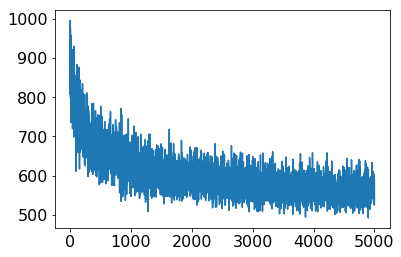

In [465]:
plt.plot(hkl[1][:, 2])

In [489]:
#network.save('../local_data/hydrocarbon_cyc9/network_MLKL_longer.pkl')

Std z = 0.9958544


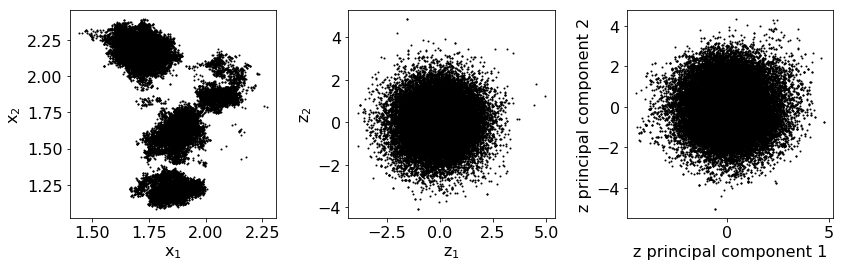

In [493]:
test_xz_projection(network.Txz, [xtrain])
print('Std z =', network.std_z(xtrain))

Traj  0 Fraction of low energies:  0.9733
Traj  0 Minimum energy:  142.086443901062
Traj  1 Fraction of low energies:  0.9733
Traj  1 Minimum energy:  142.086443901062


(<matplotlib.figure.Figure at 0x188fc01da0>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x187ddcd898>,
       dtype=object))

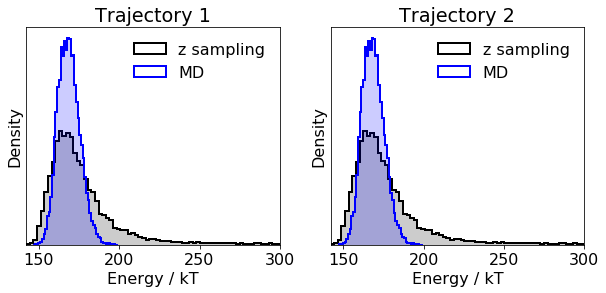

In [494]:
sz, sx, Ez, Ex, logw = network.sample(temperature=1.0, nsample=10000)
test_generate_x(mm_cyc9, [xtrain, xtrain], Ex, colors=['blue', 'blue'], max_energy=300)

In [495]:
trajgen = mdtraj.Trajectory(sx.reshape((sx.shape[0], toppar_cyc9.natoms, 3)), top_cyc9)
trajgen = trajgen.superpose(traj[0])
# permute_align(trajgen, traj[0])

In [496]:
view = nglview.show_mdtraj(trajgen)
view.camera = 'orthographic'
view

NGLWidget(count=10000)

In [497]:
torsions = mm_cyc9.torsions(trajgen.xyz.reshape(trajgen.xyz.shape[0], 3*toppar_cyc9.natoms))[:, np.array(Ctor)]
tor_i_gen = rotamer_mapper.torsion2index(torsions)

In [498]:
di_gen, k_gen, c_gen = rotamer_mapper.histogram(tor_i_gen)
for i in range(len(c_gen)):
    p_i = c_gen[i] / c_gen.sum()
    It = np.where(tor_i_gen == di_gen[i])[0]
    print(di_gen[i], '\t', k_gen[i], '\t', p_i, '\t', -np.log(p_i), '\t', Ex[It].min())

1016 	 [0 0 1 1 0 1 1 2 2] 	 0.32154551407989523 	 1.134616177424112 	 149.04438400268555
1195 	 [0 0 1 1 2 2 0 2 1] 	 0.0001309757694826457 	 8.940498217652733 	 1173.5445639491081
1292 	 [0 0 1 2 0 2 2 1 2] 	 0.25199738048461034 	 1.3783365864270811 	 150.24610471725464
3028 	 [0 1 1 0 1 1 0 1 1] 	 0.416633922724296 	 0.8755473259035887 	 142.086443901062
3046 	 [0 1 1 0 1 1 2 1 1] 	 0.0026195153896529143 	 5.944765944098742 	 181.39841556549072
3382 	 [0 1 1 1 2 2 0 2 1] 	 0.0002619515389652914 	 8.247351037092788 	 785.057505607605
3478 	 [0 1 1 2 0 2 2 1 1] 	 0.0006548788474132286 	 7.3310603052186325 	 686.5585474967957
3877 	 [0 1 2 0 2 2 1 2 1] 	 0.0006548788474132286 	 7.3310603052186325 	 486.44172191619873
5552 	 [0 2 1 1 2 1 1 2 2] 	 0.0001309757694826457 	 8.940498217652733 	 1001.8294914960861
5660 	 [0 2 1 2 0 2 1 2 2] 	 0.004715127701375246 	 5.356979279196623 	 158.64140462875366
5741 	 [0 2 1 2 1 2 1 2 2] 	 0.0005239030779305828 	 7.554203856532842 	 239.0311331748962

Load data and trained networks
----

In [27]:
# load traj simulated elsewhere
sx_md_loaded = load_obj('../local_data/hydrocarbon_cyc9/remd_data.pkl')['trajs'][0][10000:14000]
traj_md_loaded = mdtraj.Trajectory(sx_md_loaded.reshape((sx_md_loaded.shape[0], int(sx_md_loaded.shape[1]/3), 3)), 
                                   top_cyc9)
traj_md_loaded = traj_md_loaded.superpose(traj_md_loaded[0])
Ex_md_loaded = mm_cyc9.energy(sx_md_loaded)
torsions_lo, torsion_index_lo, rotamer_index_lo, rotamer_key_lo, rotamer_count_lo = list_rotamers(sx_md_loaded,
                                                                                                  Ex_md_loaded, 
                                                                                                  Ctor)
Ex = Ex_md_loaded
traj = traj_md_loaded

10169 	 [1 1 1 2 2 1 1 2 2] 	 0.7077280650784428 	 0.3456953479416971 	 155.69555759429932
1067 	 [0 0 1 1 1 0 1 1 2] 	 0.26670540383497965 	 1.3216105861509944 	 163.45976841449738
10826 	 [1 1 2 2 1 1 2 2 2] 	 0.02440441603718768 	 3.712991177928171 	 173.5298900604248
3499 	 [0 1 1 2 1 0 1 2 1] 	 0.0011621150493898896 	 6.757513615651594 	 187.92408514022827


In [67]:
# load traj generated elsewhere
sx_resample = load_obj('../local_data/hydrocarbon_cyc9/sampleX.pkl')[:600000]
traj_resample = mdtraj.Trajectory(sx_resample.reshape((sx_resample.shape[0], int(sx_resample.shape[1]/3), 3)), 
                                  top_cyc9)
traj_resample = traj_resample.superpose(traj_md_loaded[0])
Ex_resample = [mm_cyc9.energy(sx_resample[i*100000:(i+1)*100000]) for i in range(6)]
Ex_resample = np.concatenate(Ex_resample)
torsions_re, torsion_index_re, rotamer_index_re, rotamer_key_re, rotamer_count_re = list_rotamers(sx_resample,
                                                                                                  Ex_resample, 
                                                                                                  Ctor)
sxs = sx_resample
Exs = Ex_resample
trajgen = traj_resample

3499 	 [0 1 1 2 1 0 1 2 1] 	 0.9851108593623563 	 0.01500109656705517 	 146.57874202728271
10169 	 [1 1 1 2 2 1 1 2 2] 	 0.0031226309827003178 	 5.769079368821815 	 156.39593887329102
3202 	 [0 1 1 1 0 1 1 2 1] 	 0.002635411964122963 	 5.938715766088454 	 206.69130277633667
10826 	 [1 1 2 2 1 1 2 2 2] 	 0.0025706765700462516 	 5.963586157893672 	 162.82765102386475
1310 	 [0 0 1 2 1 0 1 1 2] 	 0.0013696646536230526 	 6.593189347482554 	 363.56484961509705
3938 	 [0 1 2 1 0 1 2 1 2] 	 0.001367961090621034 	 6.5944339027147585 	 298.00061321258545
10655 	 [1 1 2 1 2 1 1 2 2] 	 0.0010664304392637202 	 6.843438245561422 	 261.1252555847168
1067 	 [0 0 1 1 1 0 1 1 2] 	 0.0009642166591425968 	 6.944194538458337 	 262.0693670511246
1148 	 [0 0 1 1 2 0 1 1 2] 	 0.0009488845921244283 	 6.960223376734237 	 412.40533223748207
3209 	 [0 1 1 1 0 1 2 1 2] 	 0.0004752940775632235 	 7.651576834840155 	 379.98900055885315
3391 	 [0 1 1 1 2 2 1 2 1] 	 0.00022827744227050877 	 8.38494881671061 	 731.7659

Plot statistics
----

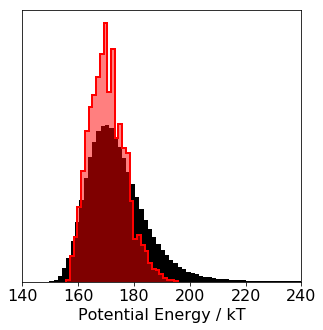

In [154]:
plt.figure(figsize=(5,5))
plt.hist(Exs[Exs < 300], 100, density=True, color='black');
plt.hist(Ex, 30, density=True, color='red', alpha=0.5);
plt.hist(Ex, 30, density=True, color='red', histtype='step', linewidth=2);
plt.xlim(140, 240)
plt.xlabel('Potential Energy / kT')
plt.yticks([])
plt.savefig('../figs/hydro_cyc9_Edist.pdf', bb_inches='tight', bbox_extra_artists=[])

In [34]:
def sample_trajectory(batchsize=100000, nbatch=5):
    sxs = []
    Exs = []
    logws = []
    for i in range(nbatch):
        sz, sx, Ez, Ex, logw = network.sample(temperature=1.0, nsample=batchsize)
        sxs.append(sx)
        Exs.append(Ex)
        logws.append(logw)
    sxs = np.vstack(sxs)
    Exs = np.concatenate(Exs)
    logws = np.concatenate(logws)
    trajgen = mdtraj.Trajectory(sxs.reshape((sxs.shape[0], toppar_cyc9.natoms, 3)), toppar_cyc9.mdtraj_topology())
    trajgen = trajgen.superpose(traj[0])
    # replace sxs by aligned version
    sxs = trajgen.xyz.reshape((sxs.shape[0], 3*toppar_cyc9.natoms))
    return sxs, Exs, logws, trajgen

In [75]:
Ns = [10, 100, 1000, 10000, 50000, 100000, 200000, 500000]
nconf = []
for N in Ns:
    traj_sub = trajgen[:N]
    tor = mm_cyc9.torsions(traj_sub.xyz.reshape(traj_sub.xyz.shape[0], 3*toppar_cyc9.natoms))[:, np.array(Ctor)]
    tor_i_gen = rotamer_mapper.torsion2index(tor)
    di_gen, k_gen, c_gen = rotamer_mapper.histogram(tor_i_gen)
    print(N, len(di_gen))
    nconf.append(len(di_gen))

10 1
100 2
1000 8
10000 12
50000 12
100000 12
200000 12
500000 12


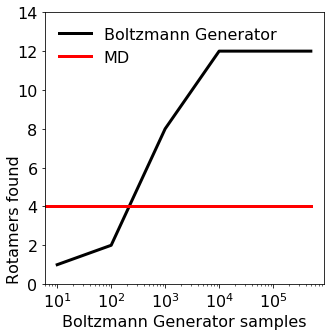

In [116]:
plt.figure(figsize=(5,5))
#plt.plot([0, 500000], [len(di_md), len(di_md)], linewidth=3, color='red', label='MD')
plt.plot(Ns, nconf, linewidth=3, color='black', label='Boltzmann Generator')
plt.plot([0, 500000], [4, 4], linewidth=3, color='red', label='MD')
plt.semilogx()
plt.ylim(0, 14)
plt.xlabel('Boltzmann Generator samples')
plt.ylabel('Rotamers found')
plt.gca().yaxis.set_label_coords(-0.08, 0.24) 
#plt.xticks([0, 250000, 500000], ['0', '250K', '500K'])
plt.legend(loc=2, frameon=False)
plt.savefig('../figs/hydro_cyc9_ngen.pdf', bb_inches='tight', bbox_extra_artists=[])

In [120]:
angles_sim = mm_cyc9.angles(traj.xyz.reshape((traj.xyz.shape[0], 3*toppar_cyc9.natoms))).flatten()
angles_gen = mm_cyc9.angles(sxs).flatten()
#w_gen = np.tile(np.exp(logw-logw.max()), 9)

In [126]:
bonds_sim = mm_cyc9.bondlengths(traj.xyz.reshape((traj.xyz.shape[0], 3*toppar_cyc9.natoms))).flatten()
bonds_gen = mm_cyc9.bondlengths(sxs).flatten()
#w_gen = np.tile(np.exp(logw-logw.max()), 9)

In [121]:
#Isel = w_gen.argsort()[::-1][1000:]

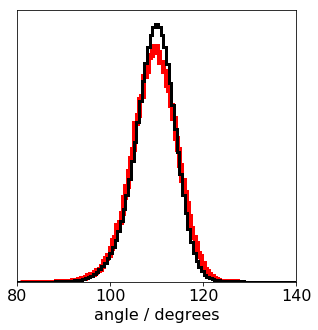

In [127]:
plt.figure(figsize=(5, 5))
plt.hist(angles_sim, 100, linewidth=5, histtype='step', density=True, color='red', label='MD');
plt.hist(angles_gen, 300, linewidth=3, histtype='step', density=True, color='black', label='Boltzmann Generator');
#plt.hist(angles_gen[Isel], 300, linewidth=2, histtype='step', density=True, weights=w_gen[Isel]);
plt.xlim(80, 140)
plt.ylim(0, 0.10)
plt.xlabel('angle / degrees')
#plt.ylabel('Density')
plt.yticks([])
#plt.legend()
plt.savefig('../figs/hydro_cyc9_bondlengths.pdf')

Text(0.5,0,'bond / $\\AA$ngstrom')

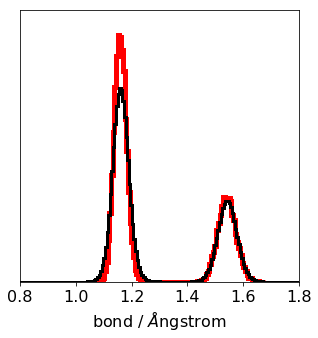

In [129]:
plt.figure(figsize=(5, 5))
plt.hist(bonds_sim, 100, linewidth=5, histtype='step', density=True, color='red');
plt.hist(bonds_gen, 300, linewidth=3, histtype='step', density=True, color='black');
#plt.hist(bonds_gen[Isel], 300, linewidth=2, histtype='step', density=True, weights=w_gen[Isel]);
plt.xlim(0.8, 1.8)
plt.ylim(0, 13)
plt.yticks([])
plt.xlabel('bond / $\AA$ngstrom')
#plt.ylabel('probability density')
#plt.savefig('/Users/noe/data/papers/BoltzmannGenerators/figs/hydro_cyc9_angles.pdf')

Write out structures for visualization
------

In [13]:
def select_from_traj(traj, traj_indices, traj_energies, selected_indices, nsample=10):
    selected_coordinates = []
    for i in selected_indices:
        time_indices = np.where(traj_indices == i)[0]
        sel_indices = time_indices[traj_energies[time_indices].argsort()[:nsample]]
        selected_coordinates.append(traj.xyz[sel_indices])
    selected_coordinates = np.concatenate(selected_coordinates, axis=0)
    return mdtraj.Trajectory(0.1*selected_coordinates, traj.top)

In [60]:
traj_write_md = select_from_traj(traj_md_loaded, torsion_index_lo, Ex_md_loaded, rotamer_index_lo, nsample=20)
traj_write_md.save_pdb('../local_data/hydrocarbon_cyc9/md_selected.pdb')

In [68]:
rotamer_index_re_sel = [10169, 1067, 10826, 3499, 3202, 10655, 1310, 3938, 10655, 1067, 1148, 3209]
traj_write_md = select_from_traj(traj_resample, torsion_index_re, Ex_resample, rotamer_index_re_sel, nsample=20)
traj_write_md.save_pdb('../local_data/hydrocarbon_cyc9/generated_selected.pdb')